# Fishery Show Analysis

In [1]:
import sys
sys.path.append('C:/Users/2093/Documents/GitHub/TradeModel/tools/')
import reader as rd
import pandas as pd

path = 'C:/Users/2093/Desktop/Data Center/03. Data/05. TAITRA/CRM/'

# Company profile
tax = pd.read_csv(path + 'tax_utf-8.csv', header=0, index_col=False,
                  names=['bogus', 'address', 'id', 'com_name', 'capital', 'est_date', 'invoice',
                         'biz1_id', 'biz1', 'biz2_id', 'biz2', 'biz3_id', 'biz3',
                         'biz4_id', 'biz4'],
                  dtype={'bogus': str,
                         'address': str,
                         'id': str,
                         'com_name': str,
                         'capital': int,
                         'est_date': int,
                         'invoice': str,
                         'biz1_id': str,
                         'biz1': str,
                         'biz2_id': str,
                         'biz2': str,
                         'biz3_id': str,
                         'biz3': str,
                         'biz4_id': str,
                         'biz4': str})
tax.set_index('id', inplace=True)
# Company trade data
trade = rd.read_company_trade()
# Events
event = pd.read_csv(path + 'crm_group.csv', usecols=range(4), header=0,
                    names=['year', 'event_name', 'source', 'event_id'])
# Event attendance
attend = pd.read_csv(path + 'crm_basic_group.csv', usecols=range(2), header=0,
                     names=['event_id', 'bogus'])
# Product descriptions
desc = rd.read_product_desc()
# Country codes
country = rd.read_country_code()
# UN import data 2015
un = rd.read_un(2015, 2015)
un['reporter'] = un['reporter'].astype(str)
un['partner'] = un['partner'].astype(str)
# UN reporters
un_rep = rd.read_country_code(source='un_rep')

#### 漁業相關活動：

In [2]:
print(event['event_name'][event['event_name'].str.contains('漁')])
ind = event['event_name'][event['event_name'].str.contains('國際漁業展\(高雄\)')].index.values

697                                 2016台灣國際漁業展一對一採購會(高雄)
762                                2016年臺灣國際漁業展(高雄)(自辦業務)
763                              高雄-2016年澎湖農漁產品國際採購洽談會供應商
765                    高雄-2016年屏東熱帶水果水產及加工品採購洽談會供應商(4月-漁)
1456                                     2015年台灣國際漁業展(高雄)
2038                                 台南-2014小農漁民出頭天，品牌大未來
3173    宏都拉斯廠商擬對台採購台灣製造之 咖啡烘乾及包裝設備/漁產箱網養殖設備/牛肉冷凍設備/自行車...
3269    宏都拉斯廠商擬對台銷售 咖啡/漁產/棕櫚油/牛肉/觀賞性植物/棉織品/汽車電子組件。歡迎有興...
Name: event_name, dtype: object


#### 分析目標：

In [3]:
from tabulate import tabulate

print(tabulate(event.iloc[ind, :], headers='keys', tablefmt='psql'))
event_id = event.ix[ind, 'event_id'].values

+------+--------+--------------------------------------+--------------------------+------------+
|      |   year | event_name                           | source                   | event_id   |
|------+--------+--------------------------------------+--------------------------+------------|
|  762 |   2016 | 2016年臺灣國際漁業展(高雄)(自辦業務) | J國內專業展-CRM_FMSPROFM | J201600045 |
| 1456 |   2015 | 2015年台灣國際漁業展(高雄)           | J國內專業展-CRM_FMSPROFM | J201500045 |
+------+--------+--------------------------------------+--------------------------+------------+


In [4]:
bogus15 = attend[attend['event_id'] == event_id[1]]['bogus'].values
bogus16 = attend[attend['event_id'] == event_id[0]]['bogus'].values

#### 2015年、2016年參展商家數：

In [5]:
id15 = tax[tax['bogus'].apply(lambda x: x in bogus15)].index
id16 = tax[tax['bogus'].apply(lambda x: x in bogus16)].index
ids  = list(set(id15) | set(id16))
print('2015年：{}家\n2016年：{}家'.format(len(id15), len(id16)))
print('不重複參展商家數：{}家'.format(len(ids)))

2015年：167家
2016年：133家
不重複參展商家數：226家


## Part 1: 漁網買主來源國

#### 臺灣漁網出口國家（圖1）：

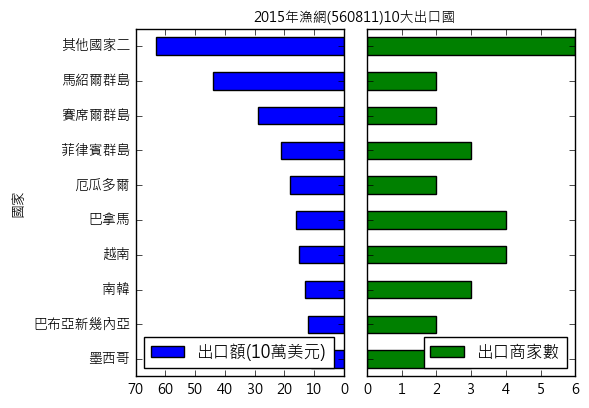

In [6]:
import matplotlib.pyplot as plt

net = '560811' 
net_ex15 = trade.loc['2015'].query('code == @net').groupby('country').agg(
    {'ex': 'sum', 'ban': 'nunique'}).merge(
    country, how='left', left_index=True, right_on='code').sort_values(
    'ex', ascending=False).head(10).sort_values('ex', ascending=True)

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2)
net_ex15[['country', 'ex']].plot(ax=axes[0], kind='barh', x='country', align='center')
net_ex15[['country', 'ban']].plot(ax=axes[1], kind='barh', align='center', color='g')
plt.suptitle('2015年漁網(560811)10大出口國', x=0.6, y=1.01)
axes[0].invert_xaxis()
axes[0].set_ylabel('國家')
axes[0].legend(['出口額(10萬美元)'], loc='lower left')
axes[1].legend(['出口商家數'], loc='lower right')
axes[1].yaxis.set_ticklabels([])
plt.tight_layout()
plt.show()

#### 單看出口商數的情況（圖2）：

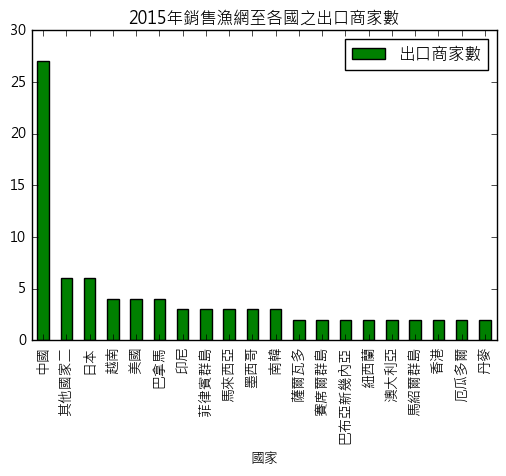

In [7]:
plt.clf()
trade.loc['2015'].query('code == @net').groupby('country').agg({'ban': 'nunique'}).merge(
    country, how='left', left_index=True, right_on='code').sort_values(
    'ban', ascending=False).head(20)[['country', 'ban']].plot(kind='bar', x='country',
    title='2015年銷售漁網至各國之出口商家數', color='g')
plt.legend(['出口商家數'])
plt.xlabel('國家')
plt.show()

#### 比較圖1及圖2，可發現出口額和出口商家數的分布，有不小的差異。

#### 接下來，比較參展廠商和非參展廠商的出口情況：

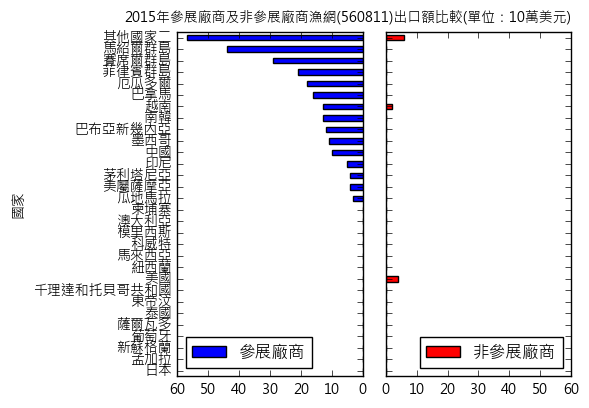

In [8]:
net_ex15 = trade.loc['2015'].query('code == @net')
net_ex15_exhi = net_ex15[net_ex15['ban'].apply(lambda x: x in ids)].groupby('country').agg(
    {'ex': 'sum'}).merge(country, how='left', left_index=True, right_on='code').sort_values(
    'ex', ascending=False)
net_ex15_nexhi = net_ex15[net_ex15['ban'].apply(lambda x: x not in ids)].groupby('country').agg(
    {'ex': 'sum'}).merge(country, how='left', left_index=True, right_on='code').sort_values(
    'ex', ascending=False)
# Countries common to top 20 lists of the two groups
top20_union = set(net_ex15_exhi.head(20)['country'].values) | set(
    net_ex15_nexhi.head(20)['country'].values)

net_ex15_exhi = net_ex15_exhi[net_ex15_exhi['country'].apply(lambda x: x in top20_union)][
    ['ex', 'country']]
net_ex15_nexhi = net_ex15_nexhi[net_ex15_nexhi['country'].apply(lambda x: x in top20_union)][
    ['ex', 'country']]
net_ex15 = net_ex15_exhi.merge(net_ex15_nexhi, how='outer', on='country').fillna(0).sort_values('ex_x')

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2)
net_ex15[['country', 'ex_x']].plot(ax=axes[0], kind='barh', x='country', align='center')
net_ex15[['country', 'ex_y']].plot(ax=axes[1], kind='barh', align='center', color='r')
plt.suptitle('2015年參展廠商及非參展廠商漁網(560811)出口額比較(單位：10萬美元)', x=0.59, y=1.01)
axes[0].invert_xaxis()
axes[0].set_ylabel('國家')
axes[0].legend(['參展廠商'], loc='lower left')
axes[1].legend(['非參展廠商'], loc='lower right')
axes[1].yaxis.set_ticklabels([])
axes[1].set_xlim(0, 60)
plt.tight_layout()
plt.show()

#### 結果顯示：參展廠商已包辦了絕大多數的漁網出口國。（或者換句話說：漁展已網羅幾乎所有重要漁網出口商。）

#### 比較各國自全球進口：

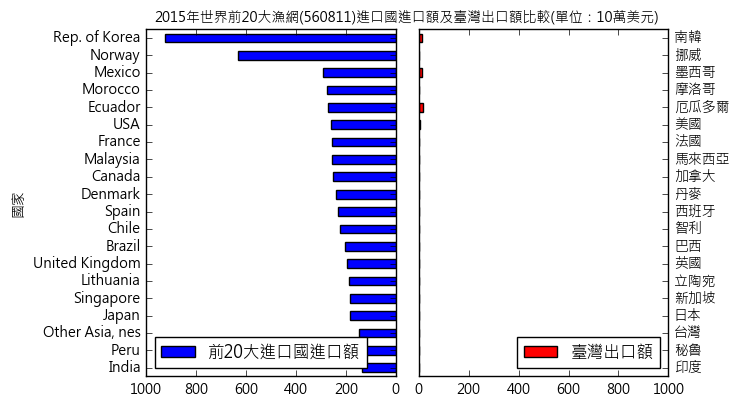

In [9]:
net_im = un.query('commodity == @net').groupby('reporter').agg(
    {'val': 'sum'})
net_im = net_im.assign(val=net_im['val'] / 1e5).sort_values('val', ascending=False).merge(
    un_rep, how='left', left_index=True, right_on='code')[['country', 'val']].head(20)
im_top20 = ['南韓', '挪威', '墨西哥', '摩洛哥', '厄瓜多爾', '美國', '法國', '馬來西亞', '加拿大',
            '丹麥', '西班牙', '智利', '巴西', '英國', '立陶宛', '新加坡', '日本', '台灣', '秘魯', '印度']

top20_code = country[country['country'].apply(lambda x: x in im_top20)]['code'].values
net_2top20 = trade.loc['2015'].query('code == @net & country in @top20_code').groupby('country').agg(
    {'ex': 'sum'}).merge(country, how='left', left_index=True, right_on='code')[['country', 'ex']]
net_2top20 = pd.concat(
    [net_2top20,
     pd.DataFrame({'country':[x for x in im_top20 if x not in net_2top20['country'].values],
                   'ex': 0})])
net_2top20 = net_2top20.iloc[
    list(map(lambda x: list(net_2top20['country'].values).index(x), im_top20))[::-1], :]

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 4))
net_im.sort_values('val').plot(ax=axes[0], kind='barh', x='country', align='center')
net_2top20.plot(ax=axes[1], kind='barh', x='country', align='center', color='r')
plt.suptitle('2015年世界前20大漁網(560811)進口國進口額及臺灣出口額比較(單位：10萬美元)', x=0.55, y=1.01)
axes[0].invert_xaxis()
axes[0].set_ylabel('國家')
axes[0].legend(['前20大進口國進口額'], loc='lower left')
axes[1].legend(['臺灣出口額'], loc='lower right')
axes[1].yaxis.tick_right()
axes[1].yaxis.label.set_visible(False)
axes[1].set_xlim(0, 1000)
plt.tight_layout()
plt.show()

## Part 2: 潛在參展商

In [10]:
exhi_product = trade.loc['2015':'2016']
exhi_product = exhi_product[exhi_product['ban'].apply(lambda x: x in ids)]

In [11]:
# Get UN product descriptions
desc_en = rd.read_product_desc(source='un')

# Find top 30 export products by exhibitors
exhi_product = exhi_product[['ban', 'code']].drop_duplicates().groupby('code').agg(
    {'ban': 'nunique'}).rename(columns={'ban': 'n_company'})
exhi_product = exhi_product.assign(ratio=exhi_product['n_company'] / len(ids) * 100).merge(
    desc, how='left', left_index=True, right_on='product').merge(
    desc_en, how='left', on='product')[['product', 'desc_x', 'desc_y', 'ratio']].sort_values(
    'ratio', ascending=False).head(30)
# Compute no. of potential exhibitors
top_product = exhi_product['product'].values
top_potential = trade[(trade['ban'].apply(lambda x: x not in ids)) &
      (trade['code'].apply(lambda x: x in top_product))].groupby('code').agg({'ban': 'nunique'})

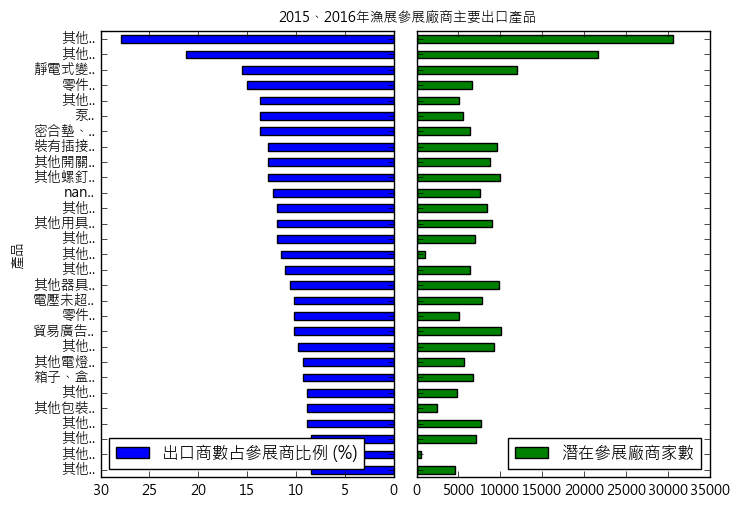

In [12]:
top_merged = exhi_product.merge(
    top_potential, how='left', left_on='product', right_index=True).sort_values('ratio').iloc[:-1, :]

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 5))
top_merged[['desc_x', 'ratio']].assign(
    desc_x=top_merged['desc_x'].astype(str).apply(lambda x: x[:4] + '..')).plot(
    ax=axes[0], kind='barh', x='desc_x', align='center')
top_merged['ban'].plot(ax=axes[1], kind='barh', align='center', color='g')
plt.suptitle('2015、2016年漁展參展廠商主要出口產品', x=0.55, y=1.01)
axes[0].invert_xaxis()
axes[0].set_ylabel('產品')
axes[0].legend(['出口商數占參展商比例 (%)'], loc='lower left')
axes[1].legend(['潛在參展廠商家數'], loc='lower right')
axes[1].yaxis.set_ticklabels([])
plt.tight_layout()
plt.show()

In [13]:
top_merged.sort_values('ratio', ascending=False).reset_index(drop=True).rename(
    columns={'product': 'HS Code', 'desc_x': '中文名稱', 'desc_y': '英文名稱', 'ratio': '占比 (%)',
            'ban': '潛在廠商家數'})

,HS Code,中文名稱,英文名稱,占比 (%),潛在廠商家數
0,392690,其他,392690 - Plastic articles nes,27.876106,30629
1,732690,其他,"732690 - Articles of iron or steel, nes",21.238938,21639
2,850440,靜電式變流器,"850440 - Static converters, nes",15.486726,11992
3,847990,零件,847990 - Parts of machines and mechanical appl...,15.044248,6671
4,841480,其他,"841480 - Air or gas compressors, hoods",13.716814,5110
5,841381,泵,841381 - Pumps nes,13.716814,5573
6,401693,密合墊、墊圈及其他封密物,"401693 - Gaskets, washers and other seals of v...",13.716814,6399
7,854442,裝有插接器者,"854442 - Other electric conductors, for a volt...",12.831858,9586
8,853650,其他開關,"853650 - Electrical switches for < 1,000 volts...",12.831858,8795
9,731815,其他螺釘及螺栓，有否附螺帽及墊圈均在內,"731815 - Bolts/screws nes, with/without nut/wa...",12.831858,10029
